In [95]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [57]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "../Images"

In [110]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [111]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [100]:
class_names = train_ds.class_names
print(class_names)

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

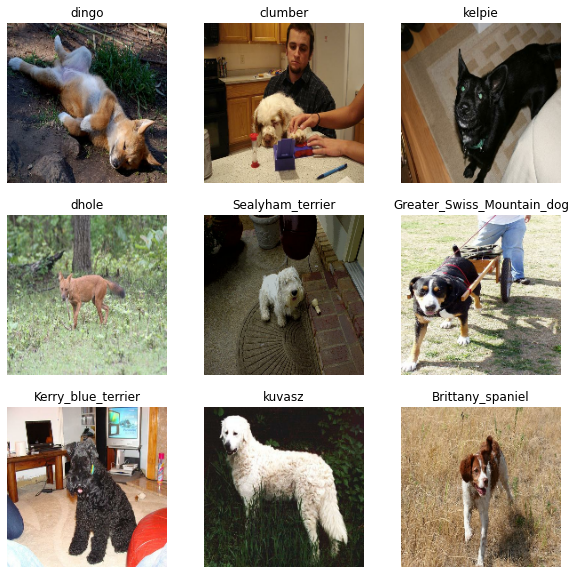

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.998366


In [105]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [107]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [112]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
515/515 [==============================] - 206s 398ms/step - loss: 4.3278 - accuracy: 0.0579 - val_loss: 4.4999 - val_accuracy: 0.0452
Epoch 2/10
515/515 [==============================] - 201s 390ms/step - loss: 3.6773 - accuracy: 0.1659 - val_loss: 5.2966 - val_accuracy: 0.0454
Epoch 3/10
515/515 [==============================] - 201s 390ms/step - loss: 2.6366 - accuracy: 0.3648 - val_loss: 7.4101 - val_accuracy: 0.0374
Epoch 4/10
515/515 [==============================] - 203s 392ms/step - loss: 1.6074 - accuracy: 0.5923 - val_loss: 10.4162 - val_accuracy: 0.0391
Epoch 5/10
515/515 [==============================] - 203s 393ms/step - loss: 0.9537 - accuracy: 0.7483 - val_loss: 13.3789 - val_accuracy: 0.0360
Epoch 6/10
515/515 [==============================] - 202s 391ms/step - loss: 0.6284 - accuracy: 0.8319 - val_loss: 15.0735 - val_accuracy: 0.0255
Epoch 7/10
515/515 [==============================] - 202s 392ms/step - loss: 0.4511 - accuracy: 0.8780 - val_loss: 17.27

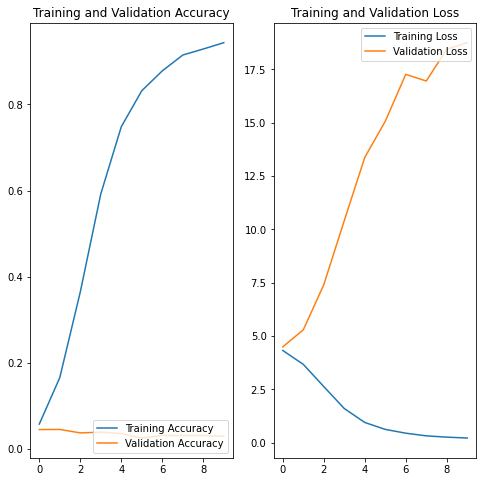

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

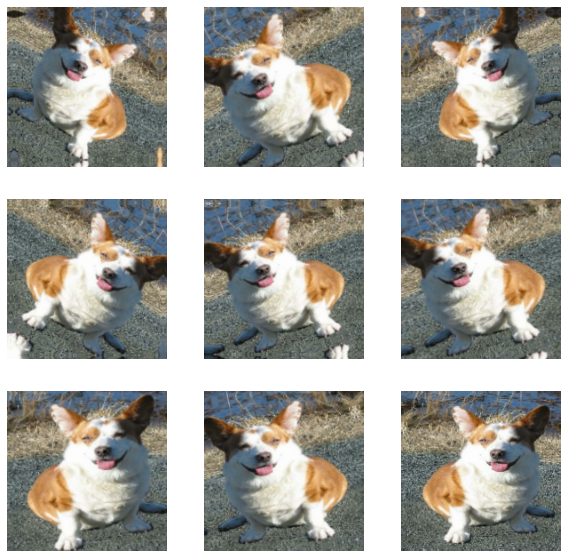

In [74]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [75]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [77]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [78]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
515/515 [==============================] - 169s 327ms/step - loss: 4.7822 - accuracy: 0.0117 - val_loss: 4.5170 - val_accuracy: 0.0233
Epoch 2/15
515/515 [==============================] - 171s 333ms/step - loss: 4.4462 - accuracy: 0.0337 - val_loss: 4.3312 - val_accuracy: 0.0437
Epoch 3/15
515/515 [==============================] - 171s 332ms/step - loss: 4.3061 - accuracy: 0.0459 - val_loss: 4.2231 - val_accuracy: 0.0552
Epoch 4/15
515/515 [==============================] - 171s 332ms/step - loss: 4.1952 - accuracy: 0.0621 - val_loss: 4.1664 - val_accuracy: 0.0644
Epoch 5/15
515/515 [==============================] - 170s 330ms/step - loss: 4.1110 - accuracy: 0.0702 - val_loss: 4.0772 - val_accuracy: 0.0702
Epoch 6/15
515/515 [==============================] - 173s 337ms/step - loss: 4.0285 - accuracy: 0.0807 - val_loss: 4.0522 - val_accuracy: 0.0746
Epoch 7/15
515/515 [==============================] - 172s 334ms/step - loss: 4.0108 - accuracy: 0.0859 - val_loss: 4.0076 -

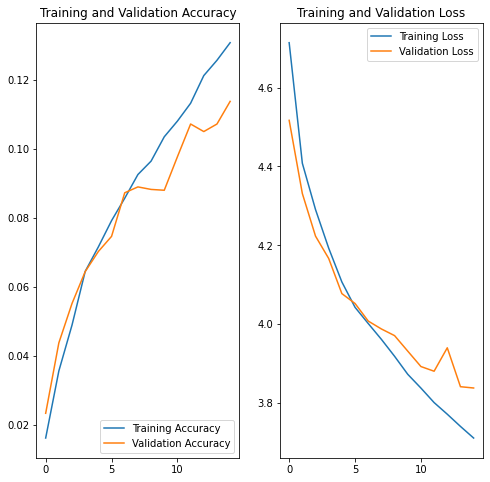

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [121]:
sunflower_url = "https://i2.wp.com/alaskadogworks.com/wp-content/uploads/2020/02/germanshorthairedpointer_puppy.jpg?resize=1010%2C673&ssl=1"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to redbone with a 59.56 percent confidence.


In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)